In [4]:
import sys, os
sys.path.insert(0, os.path.abspath('../dolphyn'))
import dolphyn as D

import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [2]:
epitope_size = 15

In [3]:
feat, labs = D.getPEDSTrainingSet(epitope_size)

AUC Test: 0.6267258382642998
AUC OOB: 0.7802958818387639
AUC Whole: 0.9918108019906992 

Accuracy: 0.5562130177514792
Precision: 0.36470588235294116
Recall: 0.5961538461538461
F1: 0.45255474452554745
Confusion Matrix:
 [[63 54]
 [21 31]]


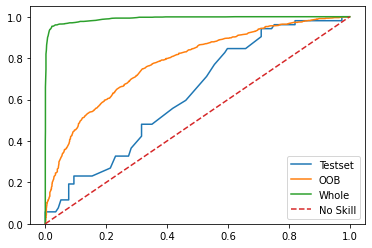

In [4]:
# train the model

clf, splitsets = D.initEpiPredictor(epi_size = epitope_size, testset_size = 0.05)
(X_test, y_test), (X_train, y_train) = splitsets

y_pred_classes =clf.predict_proba(X_test)
y_pred = np.array([classes[1] for classes in y_pred_classes])
y_labs_classes =clf.predict_proba(feat)
pred_labs = np.array([classes[1] for classes in y_labs_classes])
pred_train = np.array(clf.oob_decision_function_)[:,1]

print("AUC Test:",metrics.roc_auc_score(y_test, y_pred))
print("AUC OOB:",metrics.roc_auc_score(y_train, pred_train))
print("AUC Whole:",metrics.roc_auc_score(labs, pred_labs),"\n")

y_pred_bin =(y_pred>0.5)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_bin))
print("Precision:",metrics.precision_score(y_test, y_pred_bin))
print("Recall:",metrics.recall_score(y_test, y_pred_bin))
print("F1:",metrics.f1_score(y_test, y_pred_bin))

print("Confusion Matrix:\n",metrics.confusion_matrix(y_test, y_pred_bin))

fig_roc, ax_roc = plt.subplots()
fpr, tpr, _ = roc_curve(y_test, y_pred)
fproob, tproob, _ = roc_curve(y_train, pred_train)
fprwhole, tprwhole, _ = roc_curve(labs, pred_labs)
ax_roc.plot(fpr, tpr, label='Testset')
ax_roc.plot(fproob, tproob, label='OOB')
ax_roc.plot(fprwhole, tprwhole, label='Whole')
ax_roc.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
f_score = y_test.value_counts()[1]/len(y_test)
plt.ylim([0.0, 1.05])
#plt.savefig('RF_testset_ROC.pdf')  
ax_roc.legend()
plt.show()

In [5]:
#### Important Features for Prediction Module

clf, _ = D.initEpiPredictor(epi_size = epitope_size)
feature_imp = pd.Series(clf.feature_importances_,index=feat.columns).sort_values(ascending=False)
top = 20
print("\nTop",top,"features\n\n",feature_imp[:top], "\n")



Top 20 features

 sc_polaruncharged    0.015828
sc_poseleccharged    0.015030
d_S                  0.014434
d_K                  0.013008
sc_negeleccharged    0.013002
sc_hydrophobic       0.012375
d_KK                 0.012245
d_I                  0.011356
K                    0.010155
S                    0.010024
T                    0.009983
d_C                  0.009297
d_SK                 0.009068
E                    0.008948
A                    0.008878
P                    0.008736
d_P                  0.008566
D                    0.008501
L                    0.008470
d_KS                 0.008213
dtype: float64 



# Generate Trainingsets
(runs long)

In [6]:
# Download the public epitope dataset from Zenodo (might be slow)
#
# zenodo_url = "https://zenodo.org/record/7979557/files/hfc_pubEpitopes.csv"
# import urllib.request 
# urllib.request.urlretrieve(zenodo_url, "../data/hfc_pubEpitopes.csv")

In [7]:
hfc = pd.read_table("../data/hfc_pubEpitopes.csv", index_col = 0, sep = ",")

In [8]:
run_accident_prevent = True

if not run_accident_prevent:
    for k in [15,20,25,30,35,40,45]:
        feat = pd.DataFrame(columns = D.all_feature_names())
        labs = pd.DataFrame(columns=["reactivity", "reactivity_binary"])
        c = 0
        mersuffix = "_" + str(k) + "mer"
        print(mersuffix)
        for index, row in hfc.iterrows():      
            if mersuffix in index :  
                if c%500 == 0:
                    print(str(c), "sequences done")
                c += 1
                seq = index.split("_")[-1][-k:]
                labs.loc[index, "reactivity"] = row.sum()
                labs.loc[index, "reactivity_binary"] = 1 if sum(row > 0) > 1 else 0   
                feat.loc[index] = D.kmer_features_of_protein(seq,k).loc[0]
        feat.to_csv("peds_features"+mersuffix+".csv")
        labs.to_csv("peds_labels"+mersuffix+".csv")
else:
    print("Did you really want to run this? Set run_accident_prevent = False and try again!")

Did you really want to run this? Set run_accident_prevent = False and try again!
